# 决策树

一般流程  
1. 收集数据：可以使用任何方法。  
2. 准备数据：树构造算法只适用于标称型数据，因此数值型数据必须离散化。  
3. 分析数据：可使用任何方法，构造树完成之后，我们应该检查图形是否符合预期。  
4. 训练算法：构造树的数据结构。  
5. 测试算法：使用经验树计算错误率。  
6. 使用算法：次步骤可以适用于任何监督学习算法，而使用决策树可以更好地理解数据的内在含义。

本书使用ID3算法划分数据集（一些决策树算法采用二分法划分数据）

### 创建简单的鱼鉴定数据集

In [10]:
data_set = [
    [1,1,'yes'],
    [1,1,'yes'],
    [1,0,'no'],
    [0,1,'no'],
    [0,1,'no']
]
labels = ['能够不浮出水面', '有鳍']

In [12]:
from decision_trees_practice.trees import calc_shannon_ent

calc_shannon_ent(data_set)

0.9709505944546686

熵：度量数据集的无序程度  
熵越高，则混合的数据越多，在数据集中添加更多的分类，熵会如何变化

In [3]:
data_set1 = data_set
data_set1.append([1,1,'maybe'])

calc_shannon_ent(data_set1)

1.4591479170272448

In [6]:
def split_data_set(data_set, axis, value):
    """
    按照给定特征划分数据集，筛选某个特征为指定特征值的数据
    （然后因为是按该特征进行划分了，
    该特征在以后的划分中就不用再出现，所以把该特征在新的列表中移除）
    :param data_set: 
    :param axis: 
    :param value: 
    :return: 
    """
    ret_data_set = []
    for feature_vec in data_set:
        if feature_vec[axis] == value:
            # 抽取, 把指定特征从列表中去掉，组成一个新的特征+标签的列表
            reduced_feature_vec = feature_vec[:axis]
            reduced_feature_vec.extend(feature_vec[axis+1:])
            ret_data_set.append(reduced_feature_vec)
    return ret_data_set

In [7]:
myDat = [[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
split_data_set(myDat,0,1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [8]:
split_data_set(myDat,0,0)

[[1, 'no'], [1, 'no']]

## 选择最好的数据集划分方式  
遍历整个数据集，循环计算香农熵和split_data_set函数，找到最好的特征划分方式。熵计算将会告诉我们如何划分数据集是最好的数据组织方式  

使用"信息增益最大/熵最小"的特征进行划分

In [14]:
def choose_best_feature_to_split(data_set):
    # 特征数，取第一个样本即可得知，由于最后一个元素是标签，所以特征数是长度-1
    num_features = len(data_set[0]) - 1
    
    # 计算整个数据集的熵（无序度）
    base_entropy = calc_shannon_ent(data_set)
    
    best_info_gain = 0.0
    best_feature = -1
    
    # 遍历数据集的特征1，组成一个新的数组1， 遍历数据集的特征2，组成一个新的数组2...
    # 我的理解是，收集每一个特征都会有哪些特征值
    for i in range(num_features):
        # 创建唯一的分类标签列表
        feature_list = [example[i] for example in data_set]
        
        # 每一组特征值列表中，去掉重复的特征值
        unique_vals = set(feature_list)
        new_entropy = 0.0
        
        # 计算每种划分方式的信息熵
        for value in unique_vals:
            # 原数据集剔除了某个特征值之后的数据集
            sub_data_set = split_data_set(data_set, i, value)
            
            # 该特征值在数据集中出现的概率
            prob = len(sub_data_set)/float(len(data_set))
            
            # 计算划分后的子数据集的熵值（信息期望值总和）
            new_entropy += prob * calc_shannon_ent(sub_data_set)
            
        # 整个数据集的熵，减去划分后的子数据集的熵，得出的是信息增益？这是什么东西呢？
        # 为什么是减？-- 信息增益是熵的减少或者是数据无序度的减少
        info_gain = base_entropy - new_entropy
        
        if (info_gain > best_info_gain):
            # 计算最好的信息增益
            best_info_gain = info_gain
            best_feature = i
    return best_feature

In [15]:
choose_best_feature_to_split(myDat)

0

就是说按第一个特征进行划分效果最好

## 递归构建决策树

In [ ]:
# 如果数据集已经处理了所有属性，但是类标签依然不是唯一的，此时需要决定如何定义该叶子节点
# 通常会采用多数表决的办法决定该叶子节点的分类
import operator

def majority_cnt(class_list):
    """
    从标签列表中得出出现次数最多的标签
    :param class_list: 应该是标签的列表
    :return: 
    """
    class_count = {}
    for vote in class_list:
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class_count = sorted(class_count.items(), 
                                key=operator.itemgetter(1), reverse=True)
    return sorted_class_count[0][0]

In [16]:
def create_tree(data_set, labels):
    """
    创建决策树
    :param data_set:    数据集，应该是一个由多个[特征值1，特征值2...., 分类标签]组成的二维数组 
    :param labels:      标签列表，包含了数据集中所有特征的标签，此算法本身其实不需要此变量
    :return: 
    >>>data_set = [
    [1,1,'yes'],
    [1,1,'yes'],
    [1,0,'no'],
    [0,1,'no'],
    [0,1,'no']
    ]
    >>>labels = ['能够不浮出水面', '有鳍']
    >>>myTree = create_tree(data_set, labels)
    >>>myTree
    {'能够不浮出水面':{0:'no', 1:{'有鳍':{0:'no', 1:'yes'}}}}
    """
    # data_set中每个元素中的最后一个是分类标签，把它们全部提取出来，组成分类标签的列表
    class_list = [example[-1] for example in data_set]
    
    # 类别完全相同则停止继续划分
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    
    # 遍历完所有特征时返回出现次数最多的
    if len(data_set[0]) == 1:   #特征都分类完了，只剩下分类标签了，所以数组大小为1
        return majority_cnt(class_list)
    
    # 特征的序号
    best_feature = choose_best_feature_to_split(data_set)
    # 特征的名字（只为了给出数据明确的含义，显示用）
    best_feature_label = labels[best_feature]   # 特征的名字
    
    my_tree = {best_feature_label:{}}
    
    # 得到列表包含的所有属性值
    del (labels[best_feature])
    feature_values = [example[best_feature] for example in data_set]    # 特征值列表
    unique_vals = set(feature_values)   # 特征值列表去重
    for value in unique_vals:
        sub_labels = labels[:]
        my_tree[best_feature_label][value] = create_tree(
            split_data_set(data_set, best_feature, value),
            sub_labels
        )
    
    return my_tree

In [17]:
myTree1 = create_tree(data_set, labels)
myTree1

{'能够不浮出水面': {0: 'no', 1: {'有鳍': {0: 'no', 1: 'yes'}}}}

## 使用Matplotlib注解绘制树形图

In [18]:
import matplotlib
import matplotlib.pyplot as plt
# 可以显示中文
matplotlib.rcParams['font.sans-serif']=['STHeiti','sans-serif']

### 一个绘制的例子

In [19]:
# 定义文本框和箭头格式
decision_node = dict(boxstyle='sawtooth', fc="0.8")
leaf_node = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle='<-')


# 绘制带箭头的注解
def plot_node(node_txt, center_point, parent_point, node_type):
    create_plot.ax1.annotate(node_txt,
                             xy=parent_point,
                             xycoords='axes fraction',
                             xytext=center_point,
                             textcoords='axes fraction',
                             va='center', ha='center', bbox=node_type,
                             arrowprops=arrow_args)

def create_plot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    create_plot.ax1 = plt.subplot(111, frameon=False)
    plot_node('决策节点', (0.5, 0.1), (0.1, 0.5), decision_node)
    plot_node('叶子节点', (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.show()


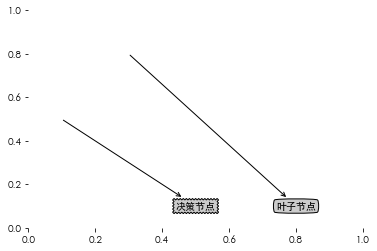

In [20]:
create_plot()